> # 실습을 시작하기에 앞서, 항상 말했던대로 ***내 드라이브*** 위치에 실습을 위한 데이터 파일들이 위치되어 있는지 확인하자.

그 후 구글 드라이브에 연결하자.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


구글 드라이브 연결이 완료되었으면 이 셀을 실행하여 실습을 위한 셋팅을 완료한다.

In [ ]:
!cp /content/gdrive/MyDrive/wikipedia2text-extracted.txt /content/

> # 실습 강의의 내용은 이 아래 부분부터 시작한다.

# **실습 2. 간단한 말뭉치 분석으로 영어 텍스트의 특징 파악하기**


본 실습에서 사용하는 데이터셋(wikipedia2text-extracted.txt)의 출처는 다음과 같음을 밝힌다.

https://www.evanjones.ca/software/wikipedia2text.html

## **0. 실습 세팅 하기**
이번 실습에서는 파이썬을 이용하여 글자와 단어 단위 각각에서 영어 텍스트를 분석하고, 그 결과를 기반으로 영어 텍스트의 특징을 추론해볼 것이다. 본격적인 과제 이행에 앞서 과제에 필요한 세팅을 진행해보자.  


---

잠깐! 본격적인 과제 시작 전, Python 문자열에 대해 간략히 복습해보자.

우선, 문자열은 각 문자의 순서 정보가 중요한 ’시퀀스‘ 객체임을 기억하며 시퀀스의 성질 4가지를 기억하자. 첫째, 튜플처럼 고정되어 있으며, 둘째, 인덱싱/슬라이싱 기능이 지원되고, 셋째, 문자별로 반복(iterate)도 가능하다. 마지막으로, 문자열의 길이는 문자열을 이루는 문자 개수로 결정된다. (줄 바꿈 \n과 같은 특수 문자 역시 단일 문자이다.)

다음은 문자열 작업에 유용한 몇 가지 리소스이다. 본 활동에서는 다양한 파이썬 문자열 메서드를 사용하니, 별도의 윈도우 창에 열어두고 사용하는 것을 추천한다.
- Python 문자열에 대한 기초 튜토리얼
: https://docs.python.org/3/tutorial/introduction.html#strings
- 문자열 메서드 리스트
: https://docs.python.org/3/library/stdtypes.html#string-methods


---
활동에 필요한 모듈인 time과 numpy, matplotlib 등을 호출해보자.


In [ ]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


우리는 'unzip' 함수를 사용할 것인데, unzip은 여러 아이템 모음을 별개의 튜플로 "풀어주는(unzip)" 함수이다. 예컨대, pairs = [("a", 1), ("b", 2), ...]에 unzip을 실행하면 (("a", "b", ...), (1, 2, ...))와 같이 여러 pair들이 풀어져 새로운 튜플을 구성하게 된다. 해당 함수를 각자 컴퓨터에서 다양하게 실행해보며 함수에 대한 직관적 이해를 높여보자.

In [ ]:
def unzip(pairs):
    """
    매개변수
    ----------
    pairs : Iterable[Tuple[Any, ...]]
        ((a0, b0, c0, ...), (a1, b1, c1, ...), ...(a2, b2, c2, ...)) 형태의 이터러블

    반환 값
    -------
    Tuple[Tuples[Any, ...], ...]
       ‘여러 쌍들(pairs)’이 ‘풀어진(unzipped)’ 내용물로 구성된 하나의 튜플; i.e.
       ((a0, a1, ...), (b0, b1, ...), (c0, c1, ...), ...)
    """
    return tuple(zip(*pairs))

In [ ]:
tuple(zip((1,2,3),(1,2,3),(1,2,3)))

((1, 1, 1), (2, 2, 2), (3, 3, 3))

In [ ]:
pairs = (("a", 1), ("b", 2), ("c", 3))
print(pairs)
print(*pairs)

(('a', 1), ('b', 2), ('c', 3))
('a', 1) ('b', 2) ('c', 3)


In [ ]:
pairs = (("a", 1), ("b", 2), ("c", 3))
print(f"*pairs :", *pairs) # unpacking -> 여러 개의 객체를 포함하고 있는 하나의 객체를 풀어줌. 가장 마지막에 있는 괄호를 풀어줌
print(f"\nzip(*pairs) :") # zip 안에는 iterable한 parameters들이 들어감.
for item in zip(*pairs):
    print(item)

print(f"\ntuple(zip(*pairs))")
print(tuple(zip(*pairs)))

*pairs : ('a', 1) ('b', 2) ('c', 3)

zip(*pairs) :
('a', 'b', 'c')
(1, 2, 3)

tuple(zip(*pairs))
(('a', 'b', 'c'), (1, 2, 3))


## **1.  영어에서 가장 자주 사용되는 글자는 무엇일까?**
게임 Wheel of Foretune의 보너스 라운드에서 참가자들은 3개의 자음과 1개의 모음을 추가로 선택하게 된다. 선택 전 기본적으로 제공되는 알파벳에는 항상 R, S, T, L, N, E가 있다. 여러 알파벳 가운데 왜 하필 R, S, T, L, N, E가 힌트로 제공되는 것일까? 위키피디아 내 영어 텍스트의 특정 말뭉치를 분석해보면, 자연스럽게 질문에 대한 답을 찾을 수 있게 된다. 지금부터 영어 텍스트 말뭉치를 분석하여, 알파벳 사용의 특징을 알아내보자!

### **1.0 데이터 준비하기**  
각자의 컴퓨터에 Evan Jones의 "wikipedia2text-extracted.txt" 전체 내용을 단일 문자열로 로드하라. 이 문서 중 일부는 ASCII가 아닌 것(ex. 몇몇 중국어 글자)을 포함하기에, 파일을 이진 읽기 모드 <mode='rb'>로 열어야 한다. 이를 통해, 일반적인 문자열 형태가 아닌, 문자에 대한 컴퓨터의 메모리 인코딩인  bytes 형태로 읽을 수 있게 된다. 만약 bytes 형태를 친숙한 문자열의 형태로 디코딩하려면, 이 bytes 인스턴스에서 메서드 decode 를 호출하면 된다.


```
with open(path_to_wikipedia, "rb") as f:
    # bytes를 string으로 디코딩
    wikipedia = f.read().decode()
```


더불어 중요한 것은, 바이트에서 문자열로 디코딩한 후에는 문자열의 모든 문자를 소문자로 만들어야 하는데, 이때 lower 메서드를 활용할 수 있다.

위 조건과 힌트를 모두 반영하여 데이터를 출력하는 코드를 작성해보자. 이를 통해 문자열에 총 6,300만 자 이상이 있다는 것을 직접 확인해보자.

인덱스 기능을 활용하여, 문자열 가운데 앞부분에 위치한 500개 글자를 출력해보자.

In [ ]:
path_to_wikipedia = "wikipedia2text-extracted.txt"

with open(path_to_wikipedia, "rb") as f:
    wikipedia = f.read().decode() # bytes를 string으로 디코딩
    wikipedia = wikipedia.lower() # 문자열의 모든 문자를 소문자로 변환
print(str(len(wikipedia)) + " character(s)")

63291831 character(s)


In [ ]:
print(wikipedia[:500])





propaganda is a concerted set of messages aimed at influencing the opinions or behavior of large numbers of people. instead of impartially providing information, propaganda in its most basic sense presents information in order to influence its audience. the most effective propaganda is often completely truthful, but some propaganda presents facts selectively to encourage a particular synthesis, or gives loaded messages in order to produce an emotional rather than rational response to the inf


### **1.1 텍스트의 글자 수 세기**
데이터가 준비되었음을 확인하였으니, 본격적으로 wikipedia 말뭉치를 이루는 모든 letter의 개수를 빠짐 없이 세어 보자.  
단어 character와 letter의 경우 별도의 번역 없이 영어 그대로 표현하겠다. 한국어로는 character과 letter을 모두 ‘문자’ 혹은 ‘글자’라고 번역하는데, 영어에서는 character를 letter의 상위 개념으로 보며 둘을 엄밀하게 구분한다. (character는 알파벳과 같은 문자뿐 아니라 숫자나 부호까지 포함한다.) 이 지점에서 한국어 번역에 어려움이 생겼기에 영어 원 단어를 있는 그대로 사용하기로 하였다.  
먼저, 구두점 및 < \n>과 같은 특수 문자를 포함하여 모든 character의 발생 횟수를 계산해보자.
* 힌트: 여러분은 파일의 모든 character 개수(count)를 한 줄로 생성할 줄 알아야 한다. Python의 collection 모듈에 있는 Counter 클래스는 각 원소별 개수를 딕셔너리 형태로 저장해주는 기능을 수행한다. Counter 클래스를 활용하면 이를 활용하면 약 5초 만에 작업을 완료할 수 있으며, 같은 일에 for 반복문을 사용한다면 약 10배 더 오래 걸릴 것이다. Counter 클래스는 추후 실습에서도 자주 등장하니 꼭 기억해두도록 하자.

In [ ]:
from collections import Counter

counter = Counter(wikipedia)

counter

Counter({'\n': 299502,
         'p': 1068764,
         'r': 3309159,
         'o': 3676394,
         'a': 4365050,
         'g': 968743,
         'n': 3740382,
         'd': 1927612,
         ' ': 10016928,
         'i': 3866921,
         's': 3390251,
         'c': 1761449,
         'e': 6091134,
         't': 4456786,
         'f': 1131994,
         'm': 1329206,
         'l': 2137466,
         'u': 1367019,
         'h': 2368877,
         'b': 756941,
         'v': 541205,
         '.': 493636,
         'y': 787683,
         ',': 648939,
         'j': 90804,
         'w': 765023,
         '(': 85894,
         '"': 101906,
         ')': 85956,
         'x': 106384,
         '1': 159377,
         '6': 45971,
         '2': 80685,
         "'": 92082,
         '-': 103163,
         '+': 806,
         '*': 291,
         'q': 52581,
         'z': 66251,
         '’': 3881,
         '‘': 282,
         'k': 293580,
         '0': 152897,
         '—': 8164,
         '?': 1098,
         '/': 

이제 우리는 내림차순으로 정렬된 letter-count 튜플 목록을 만들어야 한다. 이때 ① letter-count에는 불필요한 특수문자가 제외된 순수한 letter만 있어야 하며, ② count 값을 기준으로 내림차순으로 정렬해야 한다. 여러분이 두 가지 조건을 충족시키는 코드를 작성할 수 있도록 힌트를 드리겠다.


---
① 현재 소문자화가 이루어진 상태이므로, 특수문자를 제외한 letter만 취하기 위해서 string 모듈의 string.ascii_lowercase을 활용할 수 있다.  
```
import string  
string.ascii_lowercase  
'abcdefghijklmnopqrstuvwxyz'  
```
② Counter 클래스에 있는 most_common 메서드를 사용하면, 우리의 character-count 튜플을 내림차순으로 정렬해줄 수 있다.



>두 가지 조건을 반영한 결과물은 총 길이 26의 list 형태여야 한다.

>[('e', 6091134),  
 ('t', 4456786),  
 ('a', 4365050),  
 ('i', 3866921),  
 ('n', 3740382),  
 ('o', 3676394),  
 ...  

직접 코드를 작성해보자.

In [ ]:
# 여기에 코드 작성
import string

letters = set(string.ascii_lowercase) #알파벳 소문자만 불러와줌

counts = []

for char, cnt in counter.most_common():
    if char in letters:
        counts.append((char, cnt))

print(counts)

[('e', 6091134), ('t', 4456786), ('a', 4365050), ('i', 3866921), ('n', 3740382), ('o', 3676394), ('s', 3390251), ('r', 3309159), ('h', 2368877), ('l', 2137466), ('d', 1927612), ('c', 1761449), ('u', 1367019), ('m', 1329206), ('f', 1131994), ('p', 1068764), ('g', 968743), ('y', 787683), ('w', 765023), ('b', 756941), ('v', 541205), ('k', 293580), ('x', 106384), ('j', 90804), ('z', 66251), ('q', 52581)]


이번에는 freqs 라는 변수를 만들어보자. 변수 freqs 는 튜플로 구성된 리스트이며, 이번에는 letter-count 쌍이 아닌 letter-frequency(빈도) 쌍을 취하는 것이다. 이때 ‘빈도’는 특정  letter의 개수를 말뭉치 내 전체 letter의 개수로 나눈 값으로, 일종의 비율(ratio)이다. letter-frequency는 아래와 같은 형태로 나타나게 된다.  
>[('e', 0.12081350306248849),  
 ('t', 0.088397321263964282),  
 ('a', 0.0865778000521603),  
 ...  
 ('q', 0.0010429083984244488)]  

 주의! 전체 letter의 개수를 계산할 때 앞서 계산한 letter-count 튜플을 그대로 합해서는 안 되며, 튜플 내 숫자 부분끼리의 합을 계산해야 한다.

In [17]:
# 여기에 코드 작성
total = 0

for _, cnt in counts:
    total += cnt

freqs = []
for char, cnt in counts:
    freqs.append((char, cnt/total)) #전체에서 몇번나왔는지 빈도(확률)

print(freqs)

[('e', 0.12081350306248849), ('t', 0.08839732126396428), ('a', 0.0865778000521603), ('i', 0.07669774988957738), ('n', 0.07418793482656542), ('o', 0.0729187763358866), ('s', 0.06724332440742638), ('r', 0.06563491970144826), ('h', 0.046985065292301655), ('l', 0.042395185385342864), ('d', 0.03823287392221047), ('c', 0.034937143749573935), ('u', 0.027113892773165053), ('m', 0.0263638976176978), ('f', 0.022452331632454414), ('p', 0.02119820755660234), ('g', 0.019214359000682676), ('y', 0.015623156957763548), ('w', 0.01517371125858898), ('b', 0.015013410281504741), ('v', 0.010734433346062338), ('k', 0.005822959768917474), ('x', 0.002110054336318947), ('j', 0.0018010356252359913), ('z', 0.0013140435576352325), ('q', 0.0010429083984244488)]


각 letter에 대한 빈도(frequency) 값이 모두 합해졌을 때 ‘1’이 나오는지 확인해보아라.

In [18]:
print(sum(freq for _, freq in freqs))

0.9999999999999999


### **1.2 letter frequency 히스토그램 그리기**  
지금부터는 letter의 빈도를 히스토그램으로 시각화해보도록 하겠다. 여러분이 직접 코드를 작성해볼텐데, 이를 위한 가이드라인을 제시해주겠다.  


---
① 기본 세팅 코드
fig, ax = plt.subplots()
labels, values = unzip(freqs)

② <ax.bar>를 활용하여(주피터 노트북의 Shift 탭 사용할 것) letter와 각 letter에 대한 빈도를 나타내는 막대 그래프를 그려보아라. 이때 x축은 letter-frequency에 대한 내림차순으로 각 letter를 정렬해야 한다.

③ 눈금 표시도 해야 한다. 우리는 그래프의 축에 간격을 구분하기 위해 표시하는 눈금을  ‘틱(Tick)’이라고 부른다. 우선, <ax.set_xticks>를 사용하여 그래프에 사용할 x-tick 값의 범위를 지정해야 하는데, labels의 길이로 범위를 정하는 것이 좋을 것이다. 이후,  <ax.set_xticklabels>를 사용하여 x축을 따라 눈금에 대한 labels(예: 'e', 't', 'a'...)을 나타내어라.

④ y축의 제목과 레이블 역시 지정해야 한다. 이를 위해 <set_ylabel>과 <set_title>을 사용할 수 있다.


---
위의 네 가지 조건과 힌트를 반영하여 직접 코드를 작성해보자.



Text(0.5, 1.0, 'Frequency of Letters in English')

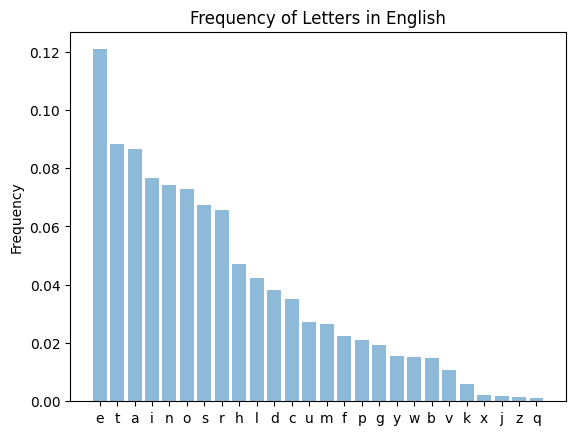

In [19]:
# 여기에 코드 작성

fig, ax = plt.subplots()
labels, values = unzip(freqs) #unzip함수로 값을 나누어서(x, y값으로 나눔)

ax.bar(range(26), values, align='center', alpha=0.5)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

ax.set_ylabel('Frequency')
ax.set_title('Frequency of Letters in English')

## **2. 영어에서 가장 자주 사용되는 단어는 무엇일까?**

지금까지는 글자 수준에서 영어 사용 분포를 파악해보았고, 이제부터는 한 수준 올라가  단어 수준에서의 분포를 살펴볼 것이다. 이를 위해 우리가 이전에 소문자로 바꿔두었던 위키백과 말뭉치로 다시 돌아가야 한다. 이번 활동에서의 핵심은 토큰화 작업이다.

### **2.0 간단한 토큰화(Tokenization)**
우선, 문자열을 여백 글자(ex. 공백, 탭, 줄 바꿈 등)을 기준으로 분할하는 간단한 토큰화 방식을 실행해보자. 말뭉치를 분할하여 ’tokens' list를 만든 후, 토큰 총개수와 처음 10개의 토큰을 출력하는 코드를 작성해보자. 이때 for-반복문을 사용하지 말고 split 함수를 활용하자.

In [23]:
tokens = wikipedia.split(' ')
print(len(tokens))
print(tokens[:10])

10016929
['\n\n\n\npropaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']


### **2.1 텍스트의 단어 수 세기**
1.1번 활동과 동일한 방식(collections 모듈의 Counter를 활용)을 활용하여, 이번에는 단어(words)의 개수를 출력해보아라.

In [24]:
word_counter = Counter(tokens)

print(len(word_counter))

# 동일한 단어는 1개로 처리

543604


In [25]:
word_counter

Counter({'\n\n\n\npropaganda': 1,
         'is': 107335,
         'a': 194624,
         'concerted': 32,
         'set': 3612,
         'of': 403043,
         'messages': 129,
         'aimed': 304,
         'at': 38495,
         'influencing': 67,
         'the': 756998,
         'opinions': 107,
         'or': 35570,
         'behavior': 454,
         'large': 6432,
         'numbers': 1444,
         'people.': 615,
         'instead': 1496,
         'impartially': 1,
         'providing': 674,
         'information,': 131,
         'propaganda': 272,
         'in': 256786,
         'its': 23722,
         'most': 19420,
         'basic': 979,
         'sense': 924,
         'presents': 199,
         'information': 1550,
         'order': 3277,
         'to': 223877,
         'influence': 1990,
         'audience.': 104,
         'effective': 753,
         'often': 7390,
         'completely': 928,
         'truthful,': 2,
         'but': 22715,
         'some': 16226,
         'facts

마지막으로, 인덱스를 활용하여 가장 자주 발생한 상위 20개 단어를 출력하라.

In [26]:
# 여기에 코드 작성

word_counter.most_common(20)

[('the', 756998),
 ('of', 403043),
 ('and', 307019),
 ('in', 256786),
 ('to', 223877),
 ('a', 194624),
 ('is', 107335),
 ('as', 94427),
 ('was', 91044),
 ('by', 75978),
 ('for', 74039),
 ('that', 72908),
 ('with', 67561),
 ('on', 61650),
 ('from', 51759),
 ('are', 51428),
 ('his', 44748),
 ('it', 41429),
 ('at', 38495),
 ('which', 37886)]

출력 결과를 살펴보자. 상위 20개 단어 list의 특징은 무엇인가? 이 list의 최상단에 사람이나 장소에 대한 고유명사나 독특한 단어를 찾을 수 있는가? 당신은 상위 20개의 단어들로부터 글의 내용에 대한 중요한 정보를 얻어낼 수 있는가? 아마 그렇지 않을 것이다. 이와 같이 자주 등장하지만 핵심 의미를 지니지 않은 채 문법적 기능을 수행하는 단어를 자연어 처리에서 ‘불용어’라고 일컫는다.  